In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '/content/drive/My Drive/Final DataSet/sagu_data.xlsx'
df = pd.read_excel(csv_file_path)

# Check if each file exists and create a mask for rows with valid file paths
def file_exists(file_path):
    return tf.io.gfile.exists(file_path)

# Filter out rows where the file does not exist
df['FileExists'] = df['Images'].apply(file_exists)
df = df[df['FileExists']].drop(columns=['FileExists'])  # Keep only rows with existing files
print(f"Removed {len(df) - df.shape[0]} rows with missing files.")

# One-hot encode the 'Category' column into separate columns
one_hot_df = pd.get_dummies(df['Category'], prefix='Category')

# Concatenate the new one-hot encoded columns with the original DataFrame
df = pd.concat([df, one_hot_df], axis=1)

# Split data into features and target
X = df['Images'].values  # Assuming the column with image paths is 'Images'
y = one_hot_df.values    # Use the one-hot encoded columns as target

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, stratify=df['Category'], random_state=42)

# Set image size and batch size
img_size = (224, 224)  # DenseNet models generally use 224x224 input size
batch_size = 32

# Preprocessing function for images
def preprocess_image(file_path):
    img = tf.keras.preprocessing.image.load_img(file_path.numpy().decode('utf-8'), target_size=img_size)
    img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    return img

# Wrap the function to allow use with `tf.py_function`
def preprocess_image_with_py_func(file_path):
    img = tf.py_function(preprocess_image, [file_path], tf.float32)
    img.set_shape(img_size + (3,))  # Specify the shape explicitly
    return img

# Prepare tf.data.Dataset for batch processing
def prepare_dataset(X, y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.map(lambda x, y: (preprocess_image_with_py_func(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Prepare train and test datasets
train_dataset = prepare_dataset(X_train, y_train)
test_dataset = prepare_dataset(X_test, y_test)

# Define the model using DenseNet201 as the base model
def create_model(input_shape, num_classes):
    # Load the DenseNet201 model with pre-trained ImageNet weights
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Set to True if you want to fine-tune the DenseNet201 layers

    # Add custom layers on top of DenseNet201
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Add global average pooling layer to reduce dimensions
    x = Dropout(0.3)(x)  # Add dropout for regularization
    output = Dense(num_classes, activation='softmax')(x)  # Add final dense layer for classification

    # Create the final model
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Create the model
input_shape = (224, 224, 3)
num_classes = y.shape[1]  # Number of one-hot encoded classes
model = create_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with validation data to track test accuracy
history = model.fit(train_dataset, epochs=30, validation_data=test_dataset)

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Final Test Accuracy: {test_acc:.2f}")




Removed 0 rows with missing files.
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
 39/477 ━━━━━━━━━━━━━━━━━━━━ 45:45 6s/step - accuracy: 0.2840 - loss: 2.1232

KeyboardInterrupt: 

In [ ]:
# Save the model architecture and weights together in .h5 format
model.save('/content/drive/My Drive/Final DataSet/densenet_model_by_mansur.h5')
print("Model saved as densenet_model.h5")


Model saved as densenet_model.h5


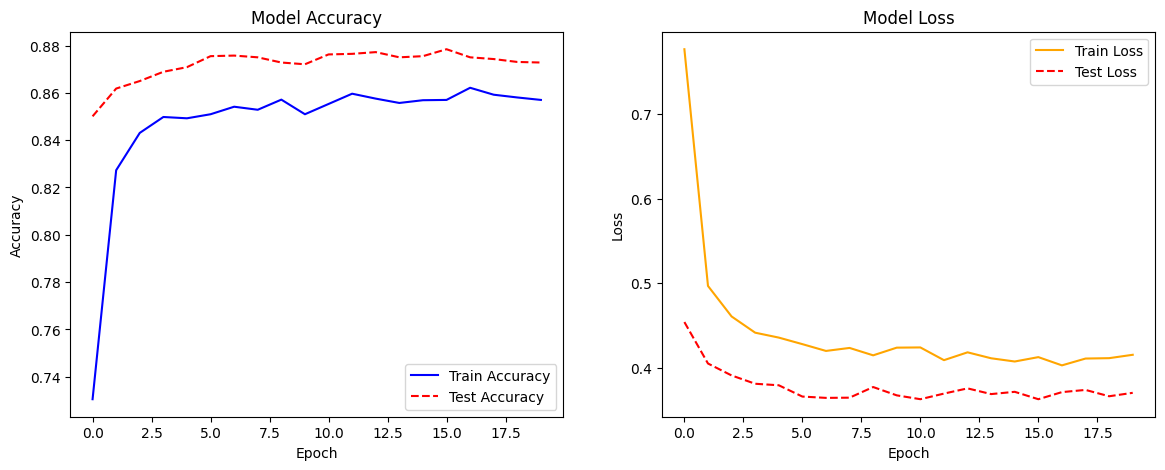

In [ ]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(14, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', color='red', linestyle='--')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='orange')
plt.plot(history.history['val_loss'], label='Test Loss', color='red', linestyle='--')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

128/128 ━━━━━━━━━━━━━━━━━━━━ 100s 582ms/step
Classification Report:
                     precision    recall  f1-score   support

     Category_Wood       0.99      0.98      0.98       492
Category_cardboard       0.84      0.90      0.87       548
  Category_e-waste       0.94      0.87      0.90       481
    Category_glass       0.85      0.88      0.86       504
  Category_medical       0.89      0.91      0.90       539
    Category_metal       0.84      0.80      0.82       452
    Category_paper       0.86      0.83      0.85       550
  Category_plastic       0.79      0.80      0.79       523

          accuracy                           0.87      4089
         macro avg       0.87      0.87      0.87      4089
      weighted avg       0.87      0.87      0.87      4089



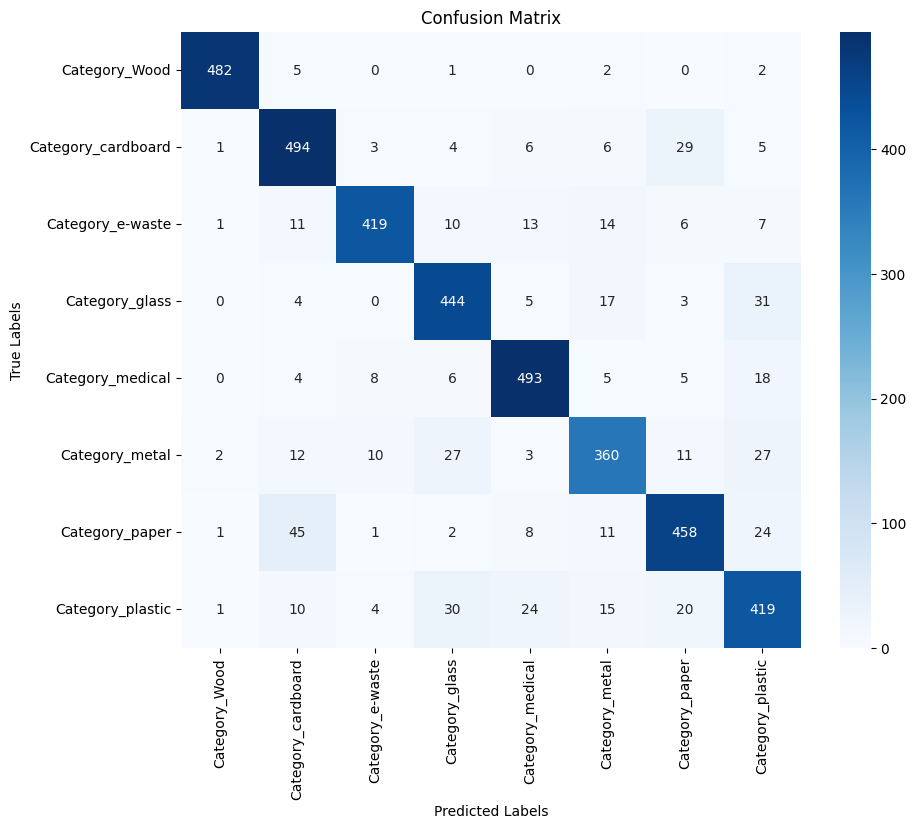

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions from the model
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot predictions to class indices

# Get true labels from the test dataset
y_true = np.concatenate([np.argmax(y, axis=1) for _, y in test_dataset], axis=0)

# Generate classification report
class_report = classification_report(y_true, y_pred_classes, target_names=one_hot_df.columns)
print("Classification Report:\n", class_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=one_hot_df.columns, yticklabels=one_hot_df.columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Training Data Results:
511/511 ━━━━━━━━━━━━━━━━━━━━ 270s 527ms/step
Training Classification Report:
                     precision    recall  f1-score   support

     Category_Wood       0.99      1.00      0.99      1966
Category_cardboard       0.89      0.93      0.91      2194
  Category_e-waste       0.98      0.93      0.95      1924
    Category_glass       0.88      0.91      0.89      2014
  Category_medical       0.94      0.95      0.95      2154
    Category_metal       0.92      0.85      0.88      1807
    Category_paper       0.90      0.86      0.88      2199
  Category_plastic       0.83      0.87      0.85      2094

          accuracy                           0.91     16352
         macro avg       0.91      0.91      0.91     16352
      weighted avg       0.91      0.91      0.91     16352



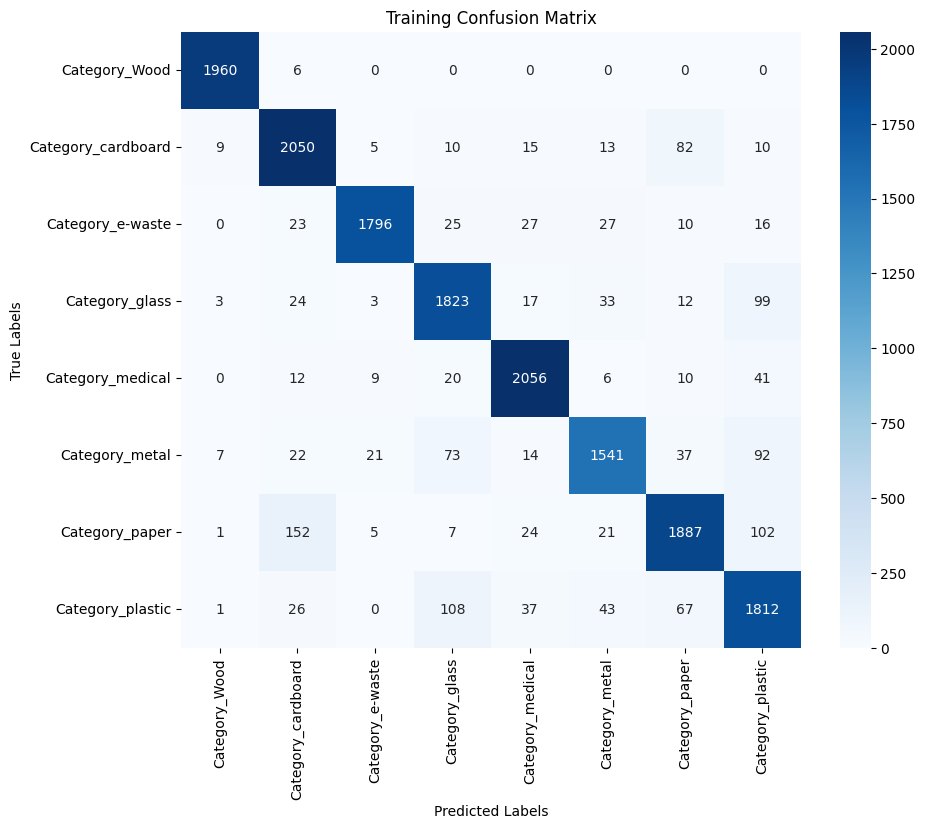

Test Data Results:
128/128 ━━━━━━━━━━━━━━━━━━━━ 80s 620ms/step
Test Classification Report:
                     precision    recall  f1-score   support

     Category_Wood       0.99      0.98      0.98       492
Category_cardboard       0.84      0.90      0.87       548
  Category_e-waste       0.94      0.87      0.90       481
    Category_glass       0.85      0.88      0.86       504
  Category_medical       0.89      0.91      0.90       539
    Category_metal       0.84      0.80      0.82       452
    Category_paper       0.86      0.83      0.85       550
  Category_plastic       0.79      0.80      0.79       523

          accuracy                           0.87      4089
         macro avg       0.87      0.87      0.87      4089
      weighted avg       0.87      0.87      0.87      4089



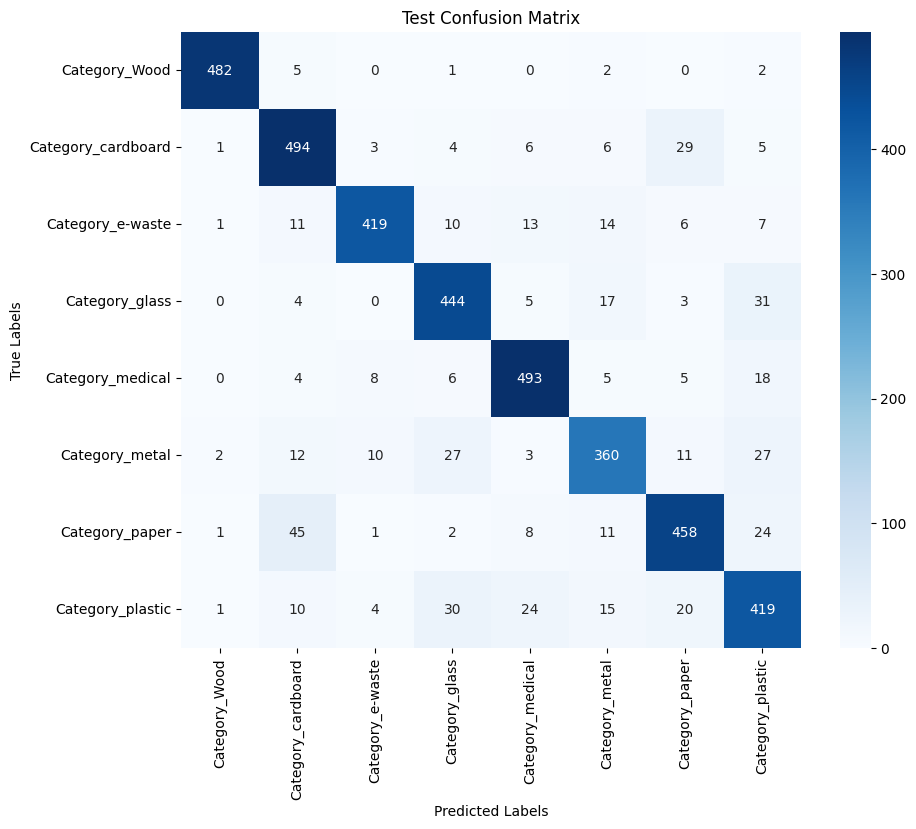

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Function to generate and plot classification report and confusion matrix
def evaluate_model(dataset, dataset_name):
    # Generate predictions
    y_pred = model.predict(dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class indices

    # Get true labels from the dataset
    y_true = np.concatenate([np.argmax(y, axis=1) for _, y in dataset], axis=0)

    # Classification report
    class_report = classification_report(y_true, y_pred_classes, target_names=one_hot_df.columns)
    print(f"{dataset_name} Classification Report:\n", class_report)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=one_hot_df.columns, yticklabels=one_hot_df.columns)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.show()

# Evaluate model on training data
print("Training Data Results:")
evaluate_model(train_dataset, "Training")

# Evaluate model on test data
print("Test Data Results:")
evaluate_model(test_dataset, "Test")
